# I. Introduction

In this exercise, you'll implement several local search algorithms and test them on the [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) (TSP) between a few dozen US state capitals.  Briefly, the TSP is an optimization problem that seeks to find the shortest path passing through every city exactly once.  In our example the TSP path is defined to start and end in the same city (so the path is a closed loop).

Local search algorithms are important in artificial intelligence because many tasks can be represented as [optimization problems](https://en.wikipedia.org/wiki/Optimization_problem).  For example, [here](https://blog.openai.com/evolution-strategies/) researches used evolutionary strategies to perform gradient-free training of deep neural networks (which allows non-differentiable activation and loss functions), and [here](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/BeamSearchDecoder) is an example of using beam search for tasks like optimal sentence translation in natural language processing.

The TSP problem itself is interesting and has been studied extensively because it can be applied to a variety of useful real-world problems. It has been used in logistics & operations research for vehicle routing and order-picking in warehouses, product development and design like computer wiring & printed circuit board masking, and various scheduling problems, among others.

![Simulated Annealing](SA_animation.gif)
Image Source: [Simulated Annealing - By Kingpin13 (Own work) [CC0], via Wikimedia Commons (Attribution not required)](https://commons.wikimedia.org/wiki/File:Hill_Climbing_with_Simulated_Annealing.gif)

## Overview

Search for `#TODO` tags to quickly find the functions you are required to implement. Descriptions and pseudocode for each function are provided in the notebook, along with links to external readings.

  0. Complete the `TravelingSalesmanProblem` class by implementing the `successors()`, `get_successor()`, and `__get_value()` methods
  0. Complete the `HillClimbingSolver` class
  0. Complete the `LocalBeamSolver` class
  0. Complete the `SimulatedAnnealingSolver` class
  0. Complete the `LAHCSolver` class

In [1]:
import json
import math 
import random
import time

from collections import deque
from itertools import chain
from helpers import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## I. Representing the Problem

The first step is to build a representation of the problem domain.  The choice of representation can have a significant impact on the performance of the various optimization algorithms.  Since the TSP deals with a closed loop that visits each city in a list once, we will represent each city by a tuple containing the city name and its position specified by an (x,y) location on a grid: (<NAME>, (x, y)).  The _state_ will then consist of an ordered sequence of the cities in the path. In other words, the path is defined as the sequence generated by traveling from each city in the list to the next in order.

For example, the path (("City1", (x1, y1)), ("City2", (x2, y2)), ("City3", (x3, y3))) defines a circuit from City1 -> City2 -> City3 -> City1. 

In [2]:
def dist(xy1, xy2):
    """ Calculate the distance between two points.
    
    You may choose to use Euclidean distance, Manhattan distance, or some
    other metric
    """
    # TODO: Implement this function!
    return math.sqrt((xy1[0] - xy2[0])**2 + (xy1[1] - xy2[1])**2)

In [3]:
class TravelingSalesmanProblem:
    """ Representation of a traveling salesman optimization problem.
    
    An instance of this class represents a complete circuit of the cities
    in the `path` attribute.
    
    
    Parameters
    ----------
    cities : iterable
        An iterable sequence of cities; each element of the sequence must be
        a tuple (name, (x, y)) containing the name and coordinates of a city
        on a rectangular grid. e.g., ("Atlanta", (585.6, 376.8))
        
    shuffle : bool
        If True, then the order of the input cities (and therefore the starting
        city) is randomized.
    
    Attributes
    ----------
    names : sequence
        An iterable sequence (list by default) containing only the names from
        the cities in the order they appear in the current TSP path

    coords : sequence
        An iterable sequence (list by default) containing only the coordinates
        from the cities in the order they appear in the current TSP path

    path : tuple
        A path between cities as specified by the order of the city
        tuples in the list.
    """
    def __init__(self, cities, shuffle = False):
        ##### YOU DO NOT NEED TO MODIFY THIS FUNCTION #####
        if shuffle:
            cities = list(cities)
            random.shuffle(cities)
        self.path = tuple(cities)  # using a tuple makes the path sequence immutable
        self.__utility = None  # access this attribute through the .utility property
     
    def copy(self, shuffle = False):
        ##### YOU DO NOT NEED TO MODIFY THIS FUNCTION #####
        cities = list(self.path)
        if shuffle: random.shuffle(cities)
        return TravelingSalesmanProblem(cities)
    
    @property
    def names(self):
        """Strip and return only the city name from each element of the
        path list. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> ["Atlanta", ...]
        """
        ##### YOU DO NOT NEED TO MODIFY THIS FUNCTION #####
        names, _ = zip(*self.path)
        return names
    
    @property
    def coords(self):
        """ Strip the city name from each element of the path list and
        return a list of tuples containing only pairs of xy coordinates
        for the cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        ##### YOU DO NOT NEED TO MODIFY THIS FUNCTION #####
        _, coords = zip(*self.path)
        return coords
    
    @property
    def utility(self):
        """ Calculate and cache the total distance of the path in the
        current state.
        """
        ##### YOU DO NOT NEED TO MODIFY THIS FUNCTION #####
        if self.__utility is None:
            self.__utility = self.__get_value()
        return self.__utility
    
    def successors(self):
        """ Return a list of states in the neighborhood of the current state.
        
        You may define the neighborhood in many different ways; although some
        will perform better than others. One method that usually performs well
        for TSP is to generate neighbors of the current path by selecting a
        starting point and an ending point in the current path and reversing
        the order of the nodes between those boundaries.
        
        For example, if the current list of cities (i.e., the path) is [A, B, C, D]
        then the neighbors will include [B, A, C, D], [C, B, A, D], and [A, C, B, D].
        (The order of successors does not matter.) 
        
        Returns
        -------
        iterable<Problem>
            A list of TravelingSalesmanProblem instances initialized with their list
            of cities set to one of the neighboring permutations of cities in the
            present state
        """
        # TODO: Implement this function!
        path_list = list(self.path)
        
        for i in range(len(path_list) - 1):
            for j in range(i + 1, len(path_list)):
                new_path = path_list[:i] + path_list[i:j][::-1] + path_list[j:]
                assert len(new_path) == len(self.path)
                yield TravelingSalesmanProblem(new_path)
        
    
    def get_successor(self):
        """ Return a random state from the neighborhood of the current state.
        
        You may define the neighborhood in many different ways; although some
        will perform better than others. One method that usually performs well
        for TSP is to generate neighbors of the current path by selecting a
        starting point and an ending point in the current path and reversing
        the order of the nodes between those boundaries.
        
        For example, if the current list of cities (i.e., the path) is [A, B, C, D]
        then the neighbors will include [B, A, C, D], [C, B, A, D], and [A, C, B, D].
        (The order of successors does not matter.) 

        Returns
        -------
        list<Problem>
            A list of TravelingSalesmanProblem instances initialized with their list
            of cities set to one of the neighboring permutations of cities in the
            present state
        """
        # TODO: Implement this function!
        new_path = random.shuffle(list(self.path))
        return TravelingSalesmanProblem(new_path)
        

    def __get_value(self):
        """ Calculate the total length of the closed-circuit path of the current
        state by summing the distance between every pair of cities in the path
        sequence. 
        
        For example, if the current path is (A, B, C, D) then the total path length is:
            
            dist = DIST(A, B) + DIST(B, C) + DIST(C, D) + DIST(D, A)
        
        You may use any distance metric that obeys the triangle inequality (e.g.,
        Manhattan distance or Euclidean distance) for the DIST() function.
        
        Since the goal of our optimizers is to maximize the value of the objective
        function, multiply the total distance by -1 so that short path lengths
        are larger numbers than long path lengths. 
        
        Returns
        -------
        float
            A floating point value with the total cost of the path given by visiting
            the cities in the order according to the self.cities list
        
        Notes
        -----
            (1) Remember to include the edge from the last city back to the first city
            
            (2) Remember to multiply the path length by -1 so that short paths have
                higher value relative to long paths
        """
        # TODO: Implement this function!
        total_distance = 0.0
        coordinates = self.coords
        
        for i in range(len(coordinates) - 1):
            total_distance += dist(coordinates[i], coordinates[i + 1])
            
        return -(total_distance + dist(coordinates[-1], coordinates[0]))

In [4]:
# Construct an instance of the TravelingSalesmanProblem and test `.__get_value()`
test_cities = [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
tsp = TravelingSalesmanProblem(test_cities)

assert round(-tsp.utility, 2) == 28.97, \
    "There was a problem with the utility value returned by your TSP class."

print("Looks good!")

Looks good!


In [5]:
# Test the successors() method
successor_paths = set([x.path for x in tsp.successors()])
expected_paths = [
    (('SF', (0, 0)), ('DC', (11, 1)), ('PHX', (2, -3)), ('LA', (0, -4))), 
    (('DC', (11, 1)), ('LA', (0, -4)), ('SF', (0, 0)), ('PHX', (2, -3))), 
    (('LA', (0, -4)), ('PHX', (2, -3)), ('DC', (11, 1)), ('SF', (0, 0)))]

assert all(contains(successor_paths, x) for x in expected_paths), \
    "It looks like your successors list does not implement the suggested neighborhood function."

print("Looks good!")

Looks good!


### Create an instance of the TSP for testing
Run the next cell to create an instance of the TSP that will be used to test each of the local search functions by finding a shortest-path circuit through several of the US state capitals.

You can increase the `num_cities` parameter (up to 30) to experiment with increasingly larger domains, and set `shuffle=True` to randomize the starting city.  Try running the solvers repeatedly -- how stable are the results?

Initial path value: 8548.59
(('Providence', (735.2, 201.2)), ('Columbus', (590.8, 263.2)), ('Salem', (80.0, 139.2)), ('Columbia', (632.4, 364.8)), ('Sacramento', (68.4, 254.0)), ('Trenton', (698.8, 239.6)), ('Little Rock', (469.2, 367.2)), ('Harrisburg', (670.8, 244.0)), ('Saint Paul', (451.6, 186.0)), ('Indianapolis', (548.0, 272.8)), ('Denver', (293.6, 274.0)), ('Atlanta', (585.6, 376.8)), ('Austin', (389.2, 448.4)), ('Oklahoma City', (392.8, 356.4)), ('Raleigh', (662.0, 328.8)), ('Lansing', (563.6, 216.4)), ('Des Moines', (447.6, 246.0)), ('Phoenix', (179.6, 371.2)), ('Salt Lake City', (204.0, 243.2)), ('Montgomery', (559.6, 404.8)), ('Boston', (738.4, 190.8)), ('Richmond', (673.2, 293.6)), ('Madison', (500.8, 217.6)), ('Nashville', (546.4, 336.8)), ('Boise', (159.6, 182.8)), ('Albany', (702.0, 193.6)), ('Tallahassee', (594.8, 434.8)), ('Baton Rouge', (489.6, 442.0)), ('Hartford', (719.6, 205.2)), ('Jackson', (501.6, 409.6)))


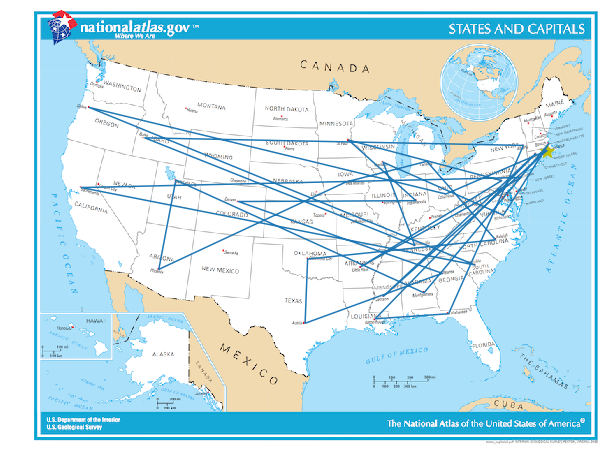

In [6]:
# Create the problem instance and plot the initial state
num_cities = 30
shuffle = True

capitals_tsp = TravelingSalesmanProblem(capitals_list[:num_cities], shuffle = shuffle)
starting_city = capitals_tsp.path[0]

print("Initial path value: {:.2f}".format(-capitals_tsp.utility))
print(capitals_tsp.path)  # The start/end point is indicated with a yellow star

show_path(capitals_tsp.coords, starting_city)

## II. Hill Climbing
Next, complete the `solve()` method for the `HillClimbingSolver` class below.

> The hill-climbing search algorithm is the most basic local search technique. At each step the current node is replaced by the neighbor with the highest value. [AIMA 3rd ed, Chapter 4]

![](pseudocode/hill_climbing.png)
Pseudocode for the [hill climbing function](https://github.com/aimacode/aima-pseudocode/blob/master/md/Hill-Climbing.md) from the AIMA textbook.  Note that our Problem class is already a "node", so the MAKE-NODE line is not required.

In [7]:
class HillClimbingSolver:
    """ 
    Parameters
    ----------
    epochs : int
        The upper limit on the number of rounds to perform hill climbing; the
        algorithm terminates and returns the best observed result when this
        iteration limit is exceeded.
    """
    
    def __init__(self, epochs = 100):
        self.epochs = epochs
    
    def solve(self, problem):
        """ Optimize the input problem by applying greedy hill climbing.

        Parameters
        ----------
        problem : Problem
            An initialized instance of an optimization problem. The Problem class
            interface must implement a callable method "successors()" which returns
            a iterable sequence (i.e., a list or generator) of the states in the
            neighborhood of the current state, and a property "utility" which returns
            a fitness score for the state. (See the `TravelingSalesmanProblem` class
            for more details.)

        Returns
        -------
        Problem
            The resulting approximate solution state of the optimization problem
            
        
        Notes
        -----
            (1) DO NOT include the MAKE-NODE line from the AIMA pseudocode
        """
        # TODO: Implement this function!
        current = problem
        
        for i in range(self.epochs):
            neighbor = max([successor for successor in current.successors()], key = lambda s: s.utility)
            
            if neighbor.utility < current.utility:
                return current
            
            current = neighbor
            
        return current

### Run the Hill Climbing Solver

solution_time: 1658.04 milliseconds
Initial path length: 8548.59
Final path length: 2163.48
(('Baton Rouge', (489.6, 442.0)), ('Austin', (389.2, 448.4)), ('Oklahoma City', (392.8, 356.4)), ('Phoenix', (179.6, 371.2)), ('Sacramento', (68.4, 254.0)), ('Salem', (80.0, 139.2)), ('Boise', (159.6, 182.8)), ('Salt Lake City', (204.0, 243.2)), ('Denver', (293.6, 274.0)), ('Des Moines', (447.6, 246.0)), ('Saint Paul', (451.6, 186.0)), ('Madison', (500.8, 217.6)), ('Lansing', (563.6, 216.4)), ('Indianapolis', (548.0, 272.8)), ('Columbus', (590.8, 263.2)), ('Harrisburg', (670.8, 244.0)), ('Albany', (702.0, 193.6)), ('Boston', (738.4, 190.8)), ('Providence', (735.2, 201.2)), ('Hartford', (719.6, 205.2)), ('Trenton', (698.8, 239.6)), ('Richmond', (673.2, 293.6)), ('Raleigh', (662.0, 328.8)), ('Columbia', (632.4, 364.8)), ('Tallahassee', (594.8, 434.8)), ('Montgomery', (559.6, 404.8)), ('Atlanta', (585.6, 376.8)), ('Nashville', (546.4, 336.8)), ('Little Rock', (469.2, 367.2)), ('Jackson', (501.6, 40

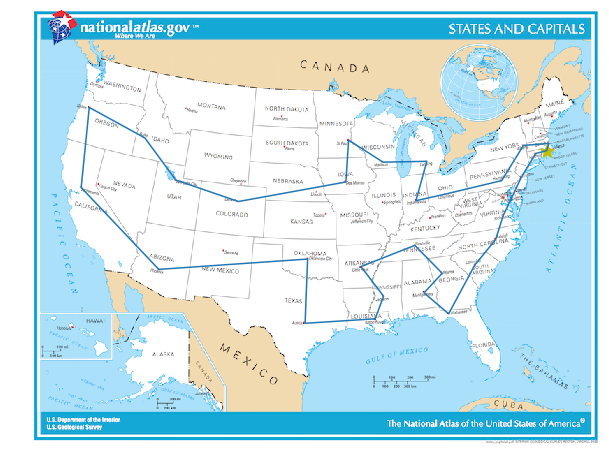

In [8]:
solver = HillClimbingSolver(epochs = 100)
start_time = time.perf_counter()
result = solver.solve(capitals_tsp)
stop_time = time.perf_counter()

print("solution_time: {:.2f} milliseconds".format((stop_time - start_time) * 1000))
print("Initial path length: {:.2f}".format(-capitals_tsp.utility))
print("Final path length: {:.2f}".format(-result.utility))
print(result.path)

show_path(result.coords, starting_city)

## III. Local Beam Search
Next, complete the `solve()` method for the `LocalBeamSolver` class below.

Local beam search is identical to the hill climbing algorithm except that it begins with k randomly generated states and at each step it selects the k best successors from the complete list of neighbors over all k states, then repeats.

In [9]:
class LocalBeamSolver:
    """
    Parameters
    ----------
    beam_width : int
        The number of samples to maintain during search.
    
    epochs : int
        The upper limit on the number of rounds to perform hill climbing; the
        algorithm terminates and returns the best observed result when this
        iteration limit is exceeded.
    """
    
    def __init__(self, beam_width = 5, epochs = 100):
        self.beam_width = beam_width
        self.epochs = epochs

    def solve(self, problem):
        """ Optimize the input problem by applying local beam search.

        Parameters
        ----------
        problem : Problem
            An initialized instance of an optimization problem. The Problem class
            interface must implement a callable method "successors()" which returns
            a iterable sequence (i.e., a list or generator) of the states in the
            neighborhood of the current state, and a property "utility" which returns
            a fitness score for the state. (See the `TravelingSalesmanProblem` class
            for more details.)

        Returns
        -------
        Problem
            The resulting approximate solution state of the optimization problem

        See Also
        --------
        local_beam_search() pseudocode
            https://
        """
        # TODO: Implement this function!
        beam = [problem]
        
        for t in range(self.epochs):
            neighborhood = chain(*(n.successors() for n in beam))
            beam = sorted(neighborhood, key = lambda x: x.utility)[-self.beam_width:]
            
            if all([node.utility < problem.utility for node in beam]):
                return beam[-1]
                
        return beam[-1]


### Run the Local Beam Search Solver

solution_time: 1710.96 milliseconds
Initial path length: 8548.59
Final path length: 2328.14
(('Baton Rouge', (489.6, 442.0)), ('Austin', (389.2, 448.4)), ('Oklahoma City', (392.8, 356.4)), ('Phoenix', (179.6, 371.2)), ('Salt Lake City', (204.0, 243.2)), ('Sacramento', (68.4, 254.0)), ('Salem', (80.0, 139.2)), ('Boise', (159.6, 182.8)), ('Denver', (293.6, 274.0)), ('Des Moines', (447.6, 246.0)), ('Saint Paul', (451.6, 186.0)), ('Madison', (500.8, 217.6)), ('Indianapolis', (548.0, 272.8)), ('Lansing', (563.6, 216.4)), ('Columbus', (590.8, 263.2)), ('Trenton', (698.8, 239.6)), ('Hartford', (719.6, 205.2)), ('Boston', (738.4, 190.8)), ('Providence', (735.2, 201.2)), ('Albany', (702.0, 193.6)), ('Harrisburg', (670.8, 244.0)), ('Richmond', (673.2, 293.6)), ('Raleigh', (662.0, 328.8)), ('Columbia', (632.4, 364.8)), ('Montgomery', (559.6, 404.8)), ('Tallahassee', (594.8, 434.8)), ('Atlanta', (585.6, 376.8)), ('Nashville', (546.4, 336.8)), ('Little Rock', (469.2, 367.2)), ('Jackson', (501.6, 40

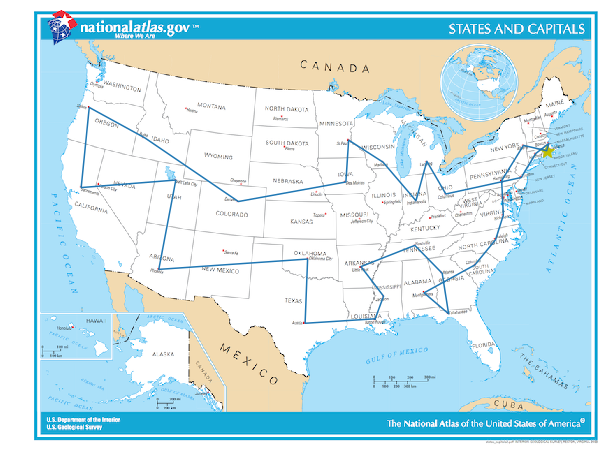

In [10]:
solver = LocalBeamSolver(beam_width = 5, epochs = 20)
start_time = time.perf_counter()
result = solver.solve(capitals_tsp)
stop_time = time.perf_counter()

print("solution_time: {:.2f} milliseconds".format((stop_time - start_time) * 1000))
print("Initial path length: {:.2f}".format(-capitals_tsp.utility))
print("Final path length: {:.2f}".format(-result.utility))
print(result.path)

show_path(result.coords, starting_city)

## IV. Simulated Annealing
Complete the `schedule()` and `solve()` methods of the `SimulatedAnnealingSolver` class below.  Simulated annealing repeatedly generates successors in the neighborhood of the current state and considers moving there according to an acceptance probability distribution parameterized by a cooling schedule.

> The simulated annealing algorithm, a version of stochastic hill climbing where some downhill moves are allowed. Downhill moves are accepted readily early in the annealing schedule and then less often as time goes on. The schedule input determines the value of the temperature T as a function of time. [AIMA 3rd ed, Chapter 4]

![](pseudocode/simulated_annealing.png)
Pseudocode for the [simulated-annealing function](https://github.com/aimacode/aima-pseudocode/blob/master/md/Simulated-Annealing.md) from the AIMA textbook.  Note that our Problem class is already a "node", so the MAKE-NODE line is not required.

In [ ]:
class SimulatedAnnealingSolver:
    """
    Parameters
    ----------
    alpha : numeric
        The decay rate parameter controlling the exponential temperature distribution.
    
    initial_temperature : numeric
        The initial temperature for the temperature distribution.
    """
    
    def __init__(self, alpha=0.95, initial_temperature=1e6):
        self.alpha = alpha
        self.initial_temperature = initial_temperature
        self.__cutoff_temperature = 1e-8  # arbitrary small constant
    
    def schedule(self, time):
        """ Return the temperature at the specified time according to the temperature schedule
        
        The most commonly used temperature schedule is an exponential:
            
            T = T_i * alpha^t
            
        Where T_i is the intial temperature, alpha is a decay rate constant, and t is the
        current time step number.
        """
        # TODO: implement this function
        raise NotImplementedError
    
    def solve(self, problem):
        """ Optimize the input problem by applying simulated annealing.

        Parameters
        ----------
        problem : Problem
            An initialized instance of an optimization problem. The Problem class
            interface must implement a callable method "get_successors()" which
            returns a random neighbor of the current states, and a property "utility"
            which returns a fitness score for the state. (See the
            `TravelingSalesmanProblem` class for more details.)

        Returns
        -------
        Problem
            The resulting approximate solution state of the optimization problem

        Notes
        -----
            (1) DO NOT include the MAKE-NODE line from the AIMA pseudocode

            (2) Modify the termination condition in the pseudocode so that the function
                returns when the temperature falls below `self.__cutoff_temperature`
        """
        # TODO: Implement this function
        raise NotImplementedError


### Run the Simulated Annealing Solver

In [ ]:
solver = SimulatedAnnealingSolver(alpha=.995, initial_temperature=1e8)
start_time = time.perf_counter()
result = solver.solve(capitals_tsp)
stop_time = time.perf_counter()
print("solution_time: {:.2f} milliseconds".format((stop_time - start_time) * 1000))
print("Initial path length: {:.2f}".format(-capitals_tsp.utility))
print("Final path length: {:.2f}".format(-result.utility))
print(result.path)
show_path(result.coords, starting_city)

## V. Late Acceptance Hill Climbing
The late acceptance hill-climbing search algorithm combines properties of both basic hill climbing and simulated annealing by accepting some downhill moves when the neighbor's value is higher than one of the previous best values in an array.

![](pseudocode/lahc.png)

You can read about LAHC (including pseudocode) in "The Late Acceptance Hill-Climbing Heuristic" by Burke & Bykov [here](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.261.3472&rep=rep1&type=pdf). (A copy of the PDF is also included in the git repo for this project.)

In [ ]:
class LAHCSolver:
    """
    Parameters
    ----------
    Lfa : numeric
        The size of the late acceptance value array.

    epochs : numeric
        The upper limit on the number of rounds to perform hill climbing; the
        algorithm terminates and returns the best observed result when this
        iteration limit is exceeded.
    """
    
    def __init__(self, Lfa=5, epochs=100):
        self.epochs = epochs
        self.Lfa = Lfa
    
    def solve(self, problem):
        """ Optimize the input problem by applying late-acceptance hill climbing.

        Parameters
        ----------
        problem : Problem
            An initialized instance of an optimization problem. The Problem class
            interface must implement a callable method "successors()" which returns
            a iterable sequence (i.e., a list or generator) of the states in the
            neighborhood of the current state, and a property "utility" which returns
            a fitness score for the state. (See the `TravelingSalesmanProblem` class
            for more details.)

        Returns
        -------
        Problem
            The resulting approximate solution state of the optimization problem

        See Also
        --------
        late_acceptance() pseudocode
            https://
        """
        # TODO: Implement this function!
        raise NotImplementedError


### Run the Late Acceptance Hill Climbing Solver

In [ ]:
solver = LAHCSolver(Lfa=5, epochs=25)
start_time = time.perf_counter()
result = solver.solve(capitals_tsp)
stop_time = time.perf_counter()
print("solution_time: {:.2f} milliseconds".format((stop_time - start_time) * 1000))
print("Initial path length: {:.2f}".format(-capitals_tsp.utility))
print("Final path length: {:.2f}".format(-result.utility))
print(result.path)
show_path(result.coords, starting_city)

## VI. Additional Experiments (Optional)
Here are some ideas for additional experiments with various settings and parameters once you've completed the lab.

  - Experiment with the parameters for each solver.  How do they affect the results?
  - Use a different schedule function for the simulated annealing solver (something other than exponential decay).  Is the algorithm still effective?
  - Use a different distance metric for get_value (e.g., we used the L2-norm (Euclidean distance), try the L1-norm (manhattan distance) or L$\infty$-norm (uniform norm)
  - Implement a genetic algorithm solver (ref: [here](https://iccl.inf.tu-dresden.de/w/images/b/b7/GA_for_TSP.pdf)) and compare with the other local search algorithms

Share and discuss your results with your peers!